In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch, numpy as np, os, random
print("PyTorch:", torch.__version__, "| CUDA available:", torch.cuda.is_available())

!pip -q install albumentations==1.4.7 timm==1.0.9

PyTorch: 2.8.0+cu126 | CUDA available: True
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.7/155.7 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 64.1 MB/s eta 0:00:00


In [ ]:
DATA_DIR = "/content/drive/MyDrive/Colab Notebooks/fer/FER-2013"
TRAIN_DIR = os.path.join(DATA_DIR, "train")
TEST_DIR  = os.path.join(DATA_DIR, "test")
assert os.path.isdir(TRAIN_DIR) and os.path.isdir(TEST_DIR), "Sai cấu trúc thư mục train/test!"
classes = sorted([d for d in os.listdir(TRAIN_DIR) if os.path.isdir(os.path.join(TRAIN_DIR, d))])
print("Classes:", classes)

Classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


## Cân bằng dữ liệu tập huấn FER-2013

Cân bằng dữ liệu cho tập huấn FER-2013 bằng cách sử dụng kỹ thuật tăng cường ảnh (image augmentation). Mục tiêu là đưa số lượng ảnh của các lớp có ít dữ liệu lên một ngưỡng mục tiêu nhất định (`TARGET_PER_CLASS`) để giảm thiểu sự mất cân bằng lớp, giúp cải thiện hiệu suất huấn luyện mô hình.

Các bước chính bao gồm:

1.  **Thiết lập đường dẫn và hằng số**: Xác định các thư mục đầu vào/đầu ra và số lượng ảnh mục tiêu cho mỗi lớp.
2.  **Phân tích phân phối lớp ban đầu**: Đếm và hiển thị số lượng ảnh cho mỗi lớp trước khi cân bằng, lưu biểu đồ và báo cáo CSV.
3.  **Tăng cường dữ liệu**: Đối với các lớp có số lượng ảnh dưới ngưỡng mục tiêu, áp dụng các phép biến đổi ngẫu nhiên (xoay, lật, cắt, điều chỉnh màu sắc, làm mờ) để tạo ra ảnh mới cho đến khi đạt được số lượng mục tiêu.
4.  **Phân tích phân phối lớp sau khi cân bằng**: Đếm và hiển thị số lượng ảnh cho mỗi lớp sau khi tăng cường, lưu biểu đồ và báo cáo CSV.
5.  **Báo cáo chi tiết tăng cường**: Lưu số lượng ảnh tăng cường được tạo ra cho mỗi lớp vào tệp CSV.
6.  **Tạo contact sheet**: Tạo các tấm ghép ảnh mẫu từ lớp có ít dữ liệu nhất để trực quan hóa sự khác biệt trước và sau khi tăng cường.

Kết quả cuối cùng là một tập dữ liệu huấn luyện mới (`FER-2013_balanced/train`) với phân phối lớp cân bằng hơn và các báo cáo chi tiết về quá trình cân bằng (`fer_reports_step2`).

Hiện trạng trước khi cân bằng: {'angry': 4041, 'disgust': 436, 'fear': 4097, 'happy': 7217, 'neutral': 4965, 'sad': 4830, 'surprise': 3171} | Tổng: 28757
Augment class 'disgust': cần thêm 3064 ảnh...
Augment class 'surprise': cần thêm 329 ảnh...
ĐÃ BỔ SUNG: {'angry': 0, 'disgust': 3064, 'fear': 0, 'happy': 0, 'neutral': 0, 'sad': 0, 'surprise': 329}
Tổng ảnh (trước → sau): 28757 → 32150


,class,count_before,count_after,delta
0,happy,7217,7217,0
1,neutral,4965,4965,0
2,sad,4830,4830,0
3,fear,4097,4097,0
4,angry,4041,4041,0
5,disgust,436,3500,3064
6,surprise,3171,3500,329


Đã lưu bảng so sánh: /content/drive/MyDrive/Colab Notebooks/fer/fer_reports_step2/class_distribution_before_after.csv


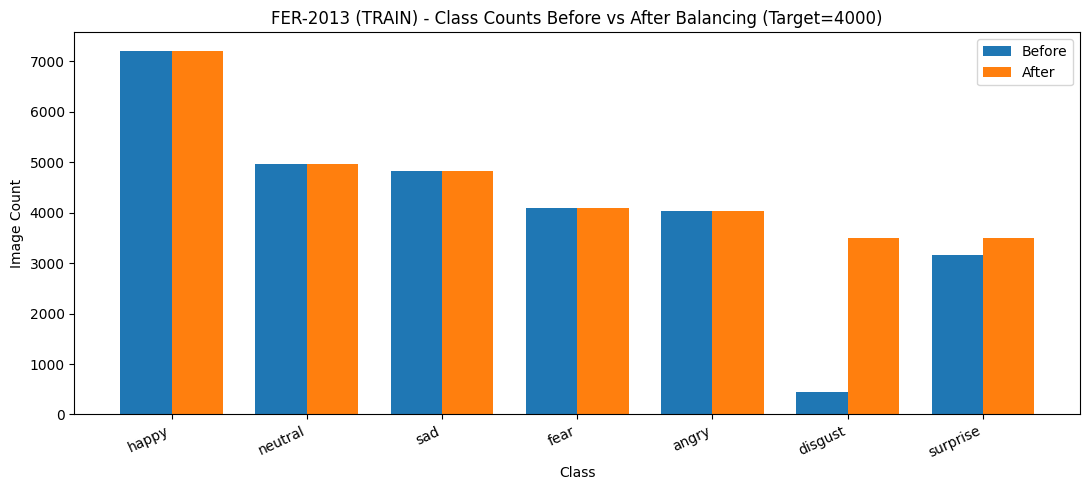

Đã lưu biểu đồ: /content/drive/MyDrive/Colab Notebooks/fer/fer_reports_step2/before_after_balance.png


In [ ]:
# ====== BƯỚC 2A: GIẢM IMBALANCE BẰNG AUGMENT CÁC LỚP THIẾU (TARGET = 3500) ======
import os, math, random, shutil
from pathlib import Path
from collections import Counter, defaultdict
import numpy as np
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt

!pip -q install albumentations==1.4.7
import albumentations as A

SRC_DIR   = "/content/drive/MyDrive/Colab Notebooks/fer/FER-2013/train"
OUT_ROOT  = "/content/drive/MyDrive/Colab Notebooks/fer/FER-2013_balanced/train"
REPORT_DIR= "/content/drive/MyDrive/Colab Notebooks/fer/fer_reports_step2"
Path(OUT_ROOT).mkdir(parents=True, exist_ok=True)
Path(REPORT_DIR).mkdir(parents=True, exist_ok=True)

TARGET_PER_CLASS = 3500
IMG_EXTS = {".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff", ".gif"}

aug = A.Compose([
    A.Resize(224, 224),
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.03, scale_limit=0.15, rotate_limit=12, p=0.7, border_mode=0),
    A.RandomBrightnessContrast(brightness_limit=0.18, contrast_limit=0.18, p=0.6),
    A.CLAHE(clip_limit=3.0, tile_grid_size=(8,8), p=0.25),
    A.GaussNoise(var_limit=(5.0, 25.0), p=0.25),
    A.CoarseDropout(max_holes=1, max_height=224//12, max_width=224//12, p=0.25),
])

# ---- Quét dữ liệu nguồn
classes = sorted([d for d in os.listdir(SRC_DIR) if os.path.isdir(os.path.join(SRC_DIR, d))])
assert len(classes) > 0, "Không thấy class nào trong train/"
src_files_by_class = {c: [] for c in classes}
for c in classes:
    cdir = os.path.join(SRC_DIR, c)
    for root, _, files in os.walk(cdir):
        for fn in files:
            if os.path.splitext(fn)[1].lower() in IMG_EXTS:
                src_files_by_class[c].append(os.path.join(root, fn))

# ---- Đếm hiện trạng
orig_counts = {c: len(src_files_by_class[c]) for c in classes}
total_orig = sum(orig_counts.values())
print("Hiện trạng trước khi cân bằng:", orig_counts, "| Tổng:", total_orig)

# ---- Chuẩn bị thư mục đích + copy toàn bộ ảnh gốc (đảm bảo dùng dataset mới đồng nhất)
for c in classes:
    out_c = Path(OUT_ROOT) / c
    out_c.mkdir(parents=True, exist_ok=True)
    # copy gốc nếu thư mục đích đang trống (tránh copy lặp khi chạy lại)
    if len(list(out_c.glob("*"))) == 0:
        for f in src_files_by_class[c]:
            # giữ tên file gốc
            shutil.copy2(f, out_c / Path(f).name)

# ---- Bổ sung ảnh cho các lớp < TARGET_PER_CLASS
rng = random.Random(42)
def load_np_rgb(path):
    img = Image.open(path).convert("RGB")
    return np.array(img)

added = {c: 0 for c in classes}
for c in classes:
    need = max(0, TARGET_PER_CLASS - orig_counts[c])
    if need == 0:
        continue
    print(f"Augment class '{c}': cần thêm {need} ảnh...")
    pool = src_files_by_class[c]
    out_c = Path(OUT_ROOT) / c
    k = 0
    while k < need:
        src = rng.choice(pool)
        arr = load_np_rgb(src)
        aug_img = aug(image=arr)["image"]
        # Lưu .png với tên duy nhất
        out_path = out_c / f"aug_{k:06d}.png"
        Image.fromarray(aug_img).save(out_path)
        k += 1
    added[c] = need

# ---- Thống kê “sau khi cân bằng”
after_counts = {}
for c in classes:
    after_counts[c] = len([f for f in os.listdir(Path(OUT_ROOT)/c)
                           if os.path.splitext(f)[1].lower() in IMG_EXTS])
total_after = sum(after_counts.values())

print("ĐÃ BỔ SUNG:", added)
print("Tổng ảnh (trước → sau):", total_orig, "→", total_after)

# ---- Xuất bảng so sánh trước/sau + biểu đồ
df_before = pd.DataFrame({"class": list(orig_counts.keys()),
                          "count_before": list(orig_counts.values())})
df_after  = pd.DataFrame({"class": list(after_counts.keys()),
                          "count_after": list(after_counts.values())})
df_merged = df_before.merge(df_after, on="class")
df_merged["delta"] = df_merged["count_after"] - df_merged["count_before"]
df_merged = df_merged.sort_values("count_after", ascending=False).reset_index(drop=True)
display(df_merged)

csv_path = Path(REPORT_DIR) / "class_distribution_before_after.csv"
df_merged.to_csv(csv_path, index=False)
print("Đã lưu bảng so sánh:", csv_path)

# ---- Vẽ biểu đồ trước/sau (2 cột cạnh nhau)
plt.figure(figsize=(11, 5))
x = np.arange(len(df_merged["class"]))
w = 0.38
plt.bar(x - w/2, df_merged["count_before"], width=w, label="Before")
plt.bar(x + w/2, df_merged["count_after"],  width=w, label="After")
plt.xticks(x, df_merged["class"], rotation=25, ha="right")
plt.title("FER-2013 (TRAIN) - Class Counts Before vs After Balancing (Target=4000)")
plt.xlabel("Class")
plt.ylabel("Image Count")
plt.legend()
plt.tight_layout()
plot_path = Path(REPORT_DIR) / "before_after_balance.png"
plt.savefig(plot_path, dpi=200)
plt.show()
print("Đã lưu biểu đồ:", plot_path)


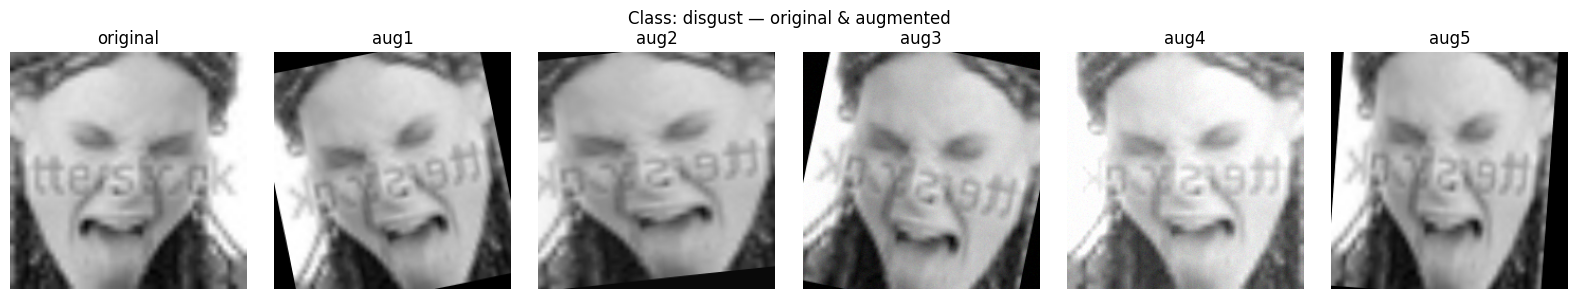

Đã lưu grid minh họa cho lớp disgust: /content/drive/MyDrive/Colab Notebooks/fer/fer_reports_step2/disgust_original_vs_aug_grid.png


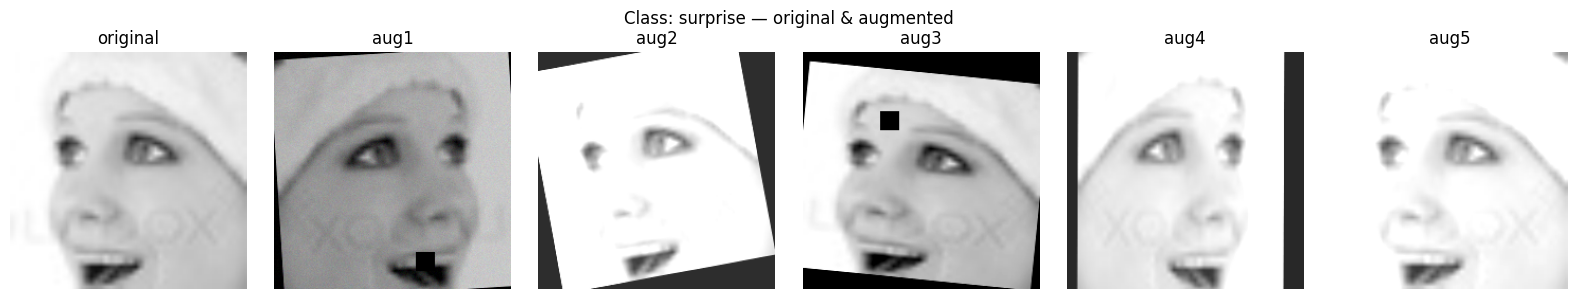

Đã lưu grid minh họa cho lớp surprise: /content/drive/MyDrive/Colab Notebooks/fer/fer_reports_step2/surprise_original_vs_aug_grid.png
✓ Đã lưu toàn bộ minh họa và ảnh đơn lẻ trong: /content/drive/MyDrive/Colab Notebooks/fer/fer_reports_step2


In [ ]:
# ====== BƯỚC 2B: MINH HỌA 2 ẢNH (GỐC → SAU XỬ LÝ) ======
import os, random
from pathlib import Path
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import albumentations as A

# Đặt lại seed cho minh họa
rng = random.Random(123)

SRC_DIR   = "/content/drive/MyDrive/Colab Notebooks/fer/FER-2013/train"
REPORT_DIR= "/content/drive/MyDrive/Colab Notebooks/fer/fer_reports_step2"
Path(REPORT_DIR).mkdir(parents=True, exist_ok=True)

# Chọn 2 lớp thiểu số nhất để minh họa (disgust, surprise)
chosen_classes = ["disgust", "surprise"]

# Aug pipeline (giống trên, nhưng đầu ra ghép grid, không resize thêm)
aug = A.Compose([
    A.Resize(224, 224),
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.03, scale_limit=0.15, rotate_limit=12, p=0.7, border_mode=0),
    A.RandomBrightnessContrast(brightness_limit=0.18, contrast_limit=0.18, p=0.6),
    A.CLAHE(clip_limit=3.0, tile_grid_size=(8,8), p=0.25),
    A.GaussNoise(var_limit=(5.0, 25.0), p=0.25),
    A.CoarseDropout(max_holes=1, max_height=224//12, max_width=224//12, p=0.25),
])

def list_images(d):
    IMG_EXTS = {".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff", ".gif"}
    out = []
    for root, _, files in os.walk(d):
        for fn in files:
            if os.path.splitext(fn)[1].lower() in IMG_EXTS:
                out.append(os.path.join(root, fn))
    return out

for c in chosen_classes:
    cdir = os.path.join(SRC_DIR, c)
    files = list_images(cdir)
    assert len(files) > 0, f"Không tìm thấy ảnh trong lớp {c}"
    src = rng.choice(files)

    # 1 gốc + 5 aug
    img0 = Image.open(src).convert("RGB")
    img0_224 = img0.resize((224,224), Image.BILINEAR)
    aug_imgs = []
    for i in range(5):
        arr = np.array(img0_224)
        aug_img = aug(image=arr)["image"]
        aug_imgs.append(Image.fromarray(aug_img))

    # Lưu từng file
    base = Path(src).stem
    out_single_dir = Path(REPORT_DIR) / f"samples_{c}"
    out_single_dir.mkdir(parents=True, exist_ok=True)

    img0_save = out_single_dir / f"{base}_original_224.png"
    img0_224.save(img0_save)
    for i, im in enumerate(aug_imgs):
        im.save(out_single_dir / f"{base}_aug{i+1}.png")

    # Ghép grid (1 dòng 6 ảnh: gốc + 5 xử lý)
    fig, axes = plt.subplots(1, 6, figsize=(16, 3))
    axes[0].imshow(img0_224); axes[0].set_title("original"); axes[0].axis("off")
    for i in range(5):
        axes[i+1].imshow(aug_imgs[i]); axes[i+1].set_title(f"aug{i+1}"); axes[i+1].axis("off")
    plt.suptitle(f"Class: {c} — original & augmented")
    plt.tight_layout()
    grid_path = Path(REPORT_DIR) / f"{c}_original_vs_aug_grid.png"
    plt.savefig(grid_path, dpi=200)
    plt.show()
    print(f"Đã lưu grid minh họa cho lớp {c}:", grid_path)

print("✓ Đã lưu toàn bộ minh họa và ảnh đơn lẻ trong:", REPORT_DIR)


# **Train mô hình**

In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/fer

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipython-input-2526712800.py", line 1, in <cell line: 0>
    get_ipython().run_line_magic('cd', '/content/drive/MyDrive/Colab Notebooks/fer')
  File "/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py", line 2418, in run_line_magic
    result = fn(*args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^
  File "<decorator-gen-85>", line 2, in cd
  File "/usr/local/lib/python3.12/dist-packages/IPython/core/magic.py", line 187, in <lambda>
    call = lambda f, *a, **k: f(*a, **k)
                              ^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/IPython/core/magics/osm.py", line 342, in cd
    oldcwd = os.getcwd()
             ^^^^^^^^^^^
OSError: [Errno 107] Transport endpoint is not connected

During handling of the above exception, another excep

In [ ]:
!python -u fer_train_singlefile_speed_patched.py \
  --train_dir "/content/drive/MyDrive/Colab Notebooks/fer/FER-2013_balanced/train" \
  --val_dir   "/content/drive/MyDrive/Colab Notebooks/fer/FER-2013/test" \
  --ckpt_dir  "/content/drive/MyDrive/FER2/checkpoints" \
  --best_dir  "/content/drive/MyDrive/FER2/weights" \
  --epochs 40 --batch_size 128 --model resnet18 \
  --num_workers 4 --autosave_minutes 30 --log_every 20


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
[OK] Class order matches class_names.json
/content/drive/.shortcut-targets-by-id/1QRj7XZt9PFVYLDL77KQfPpAaRMZtt4sP/fer/fer_train_singlefile_speed_patched.py:250: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device.type == "cuda"))
Device: cuda
Steps/epoch (train): 252 | Batch size: 128
[Resume] Loading /content/drive/MyDrive/FER2/checkpoi

In [ ]:
!python -u fer_train_singlefile_speed_patched.py \
  --train_dir "/content/drive/MyDrive/Colab Notebooks/fer/FER-2013_balanced/train" \
  --val_dir   "/content/drive/MyDrive/Colab Notebooks/fer/FER-2013/test" \
  --ckpt_dir  "/content/drive/MyDrive/FER2/checkpoints" \
  --best_dir  "/content/drive/MyDrive/FER2/weights" \
  --epochs 40 --batch_size 128 --model resnet18 \
  --num_workers 4 --autosave_minutes 30 --log_every 20


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
[OK] Class order matches class_names.json
/content/drive/.shortcut-targets-by-id/1QRj7XZt9PFVYLDL77KQfPpAaRMZtt4sP/fer/fer_train_singlefile_speed_patched.py:250: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device.type == "cuda"))
Device: cuda
Steps/epoch (train): 252 | Batch size: 128
[Resume] Loading /content/drive/MyDrive/FER2/checkpoi

In [ ]:
# === Merge ảnh 'disgust' từ SRC vào DST (tránh trùng tên + in thống kê) ===
import os, glob, uuid, shutil, pathlib
from collections import Counter

SRC = "/content/drive/MyDrive/Colab Notebooks/filtered_images"  # <-- thư mục ảnh disgust mới
DST = "/content/drive/MyDrive/Colab Notebooks/fer/FER-2013_balanced/train/disgust"  # <-- đích

exts = {".jpg",".jpeg",".png",".bmp",".tif",".tiff"}
pathlib.Path(DST).mkdir(parents=True, exist_ok=True)

def count_images_by_class(root):
    exts2 = tuple(exts)
    out = {}
    for cls in sorted(os.listdir(root)):
        p = os.path.join(root, cls)
        if os.path.isdir(p):
            n = 0
            for base,_,files in os.walk(p):
                n += sum(1 for f in files if f.lower().endswith(exts2))
            out[cls] = n
    return out

# Thống kê trước
train_root = "/content/drive/MyDrive/Colab Notebooks/fer/FER-2013_balanced/train"
before = count_images_by_class(train_root)
print("[Before] images per class:", before)

copied = 0
for p in glob.glob(SRC+'/**/*', recursive=True):
    if os.path.isfile(p) and os.path.splitext(p)[1].lower() in exts:
        name, ext = os.path.splitext(os.path.basename(p))
        out = os.path.join(DST, name+ext)
        if os.path.exists(out):
            out = os.path.join(DST, f"{name}_{uuid.uuid4().hex[:8]}{ext}")
        shutil.copy2(p, out)
        copied += 1

after = count_images_by_class(train_root)
print(f"[Merge] Copied into 'disgust': {copied}")
print("[After ] images per class:", after)


[Before] images per class: {'angry': 4041, 'disgust': 3500, 'fear': 4097, 'happy': 7217, 'neutral': 4965, 'sad': 4830, 'surprise': 3500}
[Merge] Copied into 'disgust': 758
[After ] images per class: {'angry': 4041, 'disgust': 4258, 'fear': 4097, 'happy': 7217, 'neutral': 4965, 'sad': 4830, 'surprise': 3500}


In [ ]:
import torch, pathlib
from torchvision import models as tvm
from torch import nn

BEST_PATH = "/content/drive/MyDrive/FER2/weights/resnet18_best_from_scratch.pth"  # sửa nếu khác
CKPT_DIR  = "/content/drive/MyDrive/FER2/checkpoints"
NUM_CLASSES = 7

m = tvm.resnet18(weights=None)
m.fc = nn.Sequential(nn.Dropout(0.2), nn.Linear(m.fc.in_features, NUM_CLASSES))

state = torch.load(BEST_PATH, map_location="cpu")
sd = state["model"] if isinstance(state, dict) and "model" in state else state
m.load_state_dict(sd, strict=True)

payload = {
    "epoch": 1, "global_step": 0, "best_acc": float(state.get("acc", 0.0)) if isinstance(state, dict) else 0.0,
    "model": m.state_dict(),
    "opt": None, "sched": None, "scaler": None,
    "batch_in_epoch": 0, "steps_per_epoch": 0,
}
pathlib.Path(CKPT_DIR).mkdir(parents=True, exist_ok=True)
torch.save(payload, f"{CKPT_DIR}/epoch_001.pt")
print("Wrote:", f"{CKPT_DIR}/epoch_001.pt")

Wrote: /content/drive/MyDrive/FER2/checkpoints/epoch_001.pt


In [ ]:
# Tạo thư mục ckpt mới và chuyển epoch_001.pt vào
!mkdir -p "/content/drive/MyDrive/FER2/checkpoints_ft"
!mv "/content/drive/MyDrive/FER2/checkpoints/epoch_001.pt" \
     "/content/drive/MyDrive/FER2/checkpoints_ft/"

# Chạy fine-tune, trỏ tới ckpt_dir mới
!python -u fer_train_singlefile_speed_patched.py \
  --train_dir "/content/drive/MyDrive/Colab Notebooks/fer/FER-2013_balanced/train" \
  --val_dir   "/content/drive/MyDrive/Colab Notebooks/fer/FER-2013/test" \
  --ckpt_dir  "/content/drive/MyDrive/FER2/checkpoints_ft" \
  --best_dir  "/content/drive/MyDrive/FER2/weights" \
  --epochs 12 --batch_size 128 --model resnet18 \
  --lr 3e-4 --weight_decay 1e-4 \
  --num_workers 2 --autosave_minutes 30 --log_every 20


mv: cannot stat '/content/drive/MyDrive/FER2/checkpoints/epoch_001.pt': No such file or directory
Classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
[OK] Class order matches class_names.json
/content/drive/.shortcut-targets-by-id/1QRj7XZt9PFVYLDL77KQfPpAaRMZtt4sP/fer/fer_train_singlefile_speed_patched.py:250: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device.type == "cuda"))
Device: cuda
Steps/epoch (train): 258 | Batch size: 128
[Resume] Loading /content/drive/MyDrive/FER2/checkpoints_ft/epoch_001.pt
[Resume] epoch=1 step=0 best_acc=0.0000 batch_in_epoch=0
/content/drive/.shortcut-targets-by-id/1QRj7XZt9PFVYLDL77KQfPpAaRMZtt4sP/fer/fer_train_singlefile_speed_patched.py:312: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enable